In [11]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

# === Load data ===
prices_day_0 = pd.read_csv("prices_round_3_day_0.csv", sep=";")
prices_day_1 = pd.read_csv("prices_round_3_day_1.csv", sep=";")
prices_day_2 = pd.read_csv("prices_round_3_day_2.csv", sep=";")

all_prices = pd.concat([prices_day_0, prices_day_1, prices_day_2], ignore_index=True)

# === Filter relevant rows ===
spot = all_prices[all_prices["product"] == "VOLCANIC_ROCK"]
options = all_prices[all_prices["product"].str.startswith("VOLCANIC_ROCK_VOUCHER")].copy()

# === Extract strike price from product name ===
options["strike"] = options["product"].str.extract(r'(\d+)', expand=False).astype(float)

# === Merge in spot price ===
spot = spot[["day", "timestamp", "mid_price"]].rename(columns={"mid_price": "spot_price"})
options = pd.merge(options, spot, on=["day", "timestamp"], how="left")

# === Black-Scholes model ===
def bs_call_price(S, K, T, r, sigma):
    if sigma == 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + sigma**2 / 2.) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_volatility_call(market_price, S, K, T, r):
    try:
        return brentq(lambda sigma: bs_call_price(S, K, T, r, sigma) - market_price, 1e-6, 5.0)
    except ValueError:
        return np.nan

# === Compute implied volatilities ===
T = 7 / 365  # 7 days to expiry
r = 0

options["implied_vol"] = options.apply(
    lambda row: implied_volatility_call(row["mid_price"], row["spot_price"], row["strike"], T, r),
    axis=1
)

# === Aggregate results ===
summary = options.groupby("product")["implied_vol"].mean().reset_index()
summary.columns = ["Option", "Mean Implied Volatility"]

overall = options["implied_vol"].mean()
summary.loc[len(summary.index)] = ["ALL_OPTIONS", overall]

# === Display final summary ===
print(summary)


                        Option  Mean Implied Volatility
0  VOLCANIC_ROCK_VOUCHER_10000                 0.158185
1  VOLCANIC_ROCK_VOUCHER_10250                 0.147814
2  VOLCANIC_ROCK_VOUCHER_10500                 0.150364
3   VOLCANIC_ROCK_VOUCHER_9500                 0.136681
4   VOLCANIC_ROCK_VOUCHER_9750                 0.168812
5                  ALL_OPTIONS                 0.152408


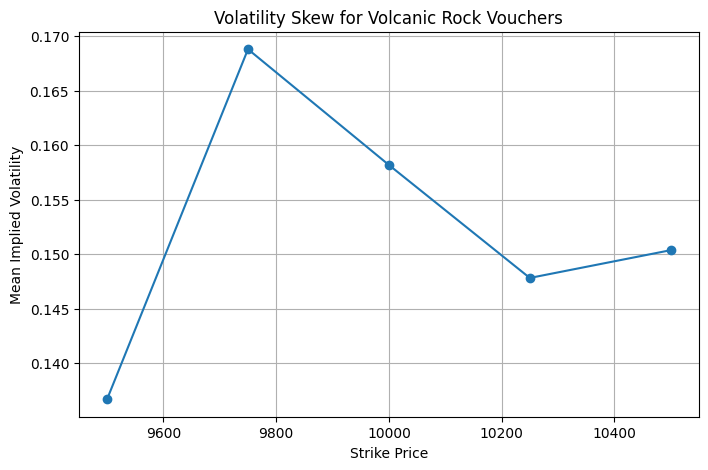

In [12]:
import matplotlib.pyplot as plt

# Sort by strike
skew_data = summary[summary["Option"] != "ALL_OPTIONS"].copy()
skew_data["strike"] = skew_data["Option"].str.extract(r'(\d+)', expand=False).astype(float)
skew_data = skew_data.sort_values("strike")

# Plot volatility skew
plt.figure(figsize=(8, 5))
plt.plot(skew_data["strike"], skew_data["Mean Implied Volatility"], marker='o')
plt.title("Volatility Skew for Volcanic Rock Vouchers")
plt.xlabel("Strike Price")
plt.ylabel("Mean Implied Volatility")
plt.grid(True)
plt.show()


In [ ]:
pip install datamodel

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/jupyter-1.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.
